In [89]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!unzip /content/bones-data.zip

Archive:  /content/bones-data.zip
replace Bone Break Classification/Bone Break Classification/Avulsion fracture/Test/000002_png.rf.c3e00ebc2db78bc94e644c3f6605dad0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [90]:
#resize
IMAGE_SIZE=[224,224]

In [91]:
#add channel
size=[224,224]+[3]
size

[224, 224, 3]

In [112]:
import os
import shutil
import glob

# --- Configuration: CHANGE THIS PATH ---
BASE_DIR = '/content/Bone Break Classification/Bone Break Classification'
OUTPUT_PATH = os.path.join(os.path.dirname(BASE_DIR), 'FLATTENED_BONE_DATA')

# Create the final train and test directories
MASTER_TRAIN_PATH = os.path.join(OUTPUT_PATH, 'train')
MASTER_TEST_PATH = os.path.join(OUTPUT_PATH, 'test')
os.makedirs(MASTER_TRAIN_PATH, exist_ok=True)
os.makedirs(MASTER_TEST_PATH, exist_ok=True)

print(f"✅ New dataset will be created at: {OUTPUT_PATH}")
# ----------------------------------------

def consolidate_files(split_type, destination_root):
    """
    Copies images into class subfolders (keeps structure for flow_from_directory).
    Example:
      BASE_DIR/Avulsion fracture/Train/img.jpg --> OUTPUT_PATH/train/Avulsion_fracture/img.jpg
    """
    search_pattern = os.path.join(BASE_DIR, '*', split_type, '*.*')
    all_files = glob.glob(search_pattern)
    count = 0

    for src_file in all_files:
        # Get class name (two levels up)
        class_name = os.path.basename(os.path.dirname(os.path.dirname(src_file)))
        class_name_clean = class_name.replace(' ', '_').replace('-', '_')

        # Create destination class folder
        class_folder = os.path.join(destination_root, class_name_clean)
        os.makedirs(class_folder, exist_ok=True)

        # Copy file
        shutil.copy2(src_file, os.path.join(class_folder, os.path.basename(src_file)))
        count += 1

    print(f"✅ Copied {count} files to {destination_root}")
    return count

# --- Execute the consolidation ---
print("\n--- Processing Training Files ---")
train_count = consolidate_files('Train', MASTER_TRAIN_PATH)

print("\n--- Processing Testing Files ---")
test_count = consolidate_files('Test', MASTER_TEST_PATH)

print("\n--- ✅ Consolidation Complete ---")
print(f"Total files moved: {train_count + test_count}")

✅ New dataset will be created at: /content/Bone Break Classification/FLATTENED_BONE_DATA

--- Processing Training Files ---
✅ Copied 989 files to /content/Bone Break Classification/FLATTENED_BONE_DATA/train

--- Processing Testing Files ---
✅ Copied 140 files to /content/Bone Break Classification/FLATTENED_BONE_DATA/test

--- ✅ Consolidation Complete ---
Total files moved: 1129


In [134]:
#define path
train_path='/content/Bone Break Classification/FLATTENED_BONE_DATA/train'
valid_path='/content/Bone Break Classification/FLATTENED_BONE_DATA/test'

In [114]:
import tensorflow as tf  # Import the TensorFlow library for deep learning tasks

from tensorflow.keras.applications.vgg16 import VGG16  # Import the pre-trained VGG16 model from Keras

from tensorflow.keras.preprocessing import image  # Provides image loading and preprocessing utilities

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img  # For image augmentation and loading images from disk

import numpy as np  # Import NumPy for numerical operations (e.g., converting images to arrays)

from glob import glob  # Used to get lists of file paths (e.g., all image files in a folder)

from tensorflow.keras.models import Sequential, Model  # Import classes to build models (Sequential or Functional API)

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten  # Import layers to build or customize neural networks

In [115]:
#load vgg16
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3],  weights='imagenet', include_top=False)

In [116]:
#check layers trainability
for layer in vgg16.layers:
  print(layer.trainable)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [117]:
#freeze the layer
for layer in vgg16.layers:
    layer.trainable = False

In [118]:
#check layer trainability
for layer in vgg16.layers:
  print(layer.name,layer.trainable)

input_layer_8 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [119]:
#architecture
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [120]:
#check how many category
folders=glob('/content/Bone Break Classification/Bone Break Classification/*')

In [121]:
folders

['/content/Bone Break Classification/Bone Break Classification/Pathological fracture',
 '/content/Bone Break Classification/Bone Break Classification/Spiral Fracture',
 '/content/Bone Break Classification/Bone Break Classification/Longitudinal fracture',
 '/content/Bone Break Classification/Bone Break Classification/Hairline Fracture',
 '/content/Bone Break Classification/Bone Break Classification/Oblique fracture',
 '/content/Bone Break Classification/Bone Break Classification/Impacted fracture',
 '/content/Bone Break Classification/Bone Break Classification/Comminuted fracture',
 '/content/Bone Break Classification/Bone Break Classification/Greenstick fracture',
 '/content/Bone Break Classification/Bone Break Classification/Fracture Dislocation',
 '/content/Bone Break Classification/Bone Break Classification/Avulsion fracture']

In [122]:
#check number of class
num_of_class=len(folders)
num_of_class

10

In [123]:
#define architecture
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(num_of_class,activation='softmax'))

In [124]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,140,042 (80.64 MB)

 Trainable params: 6,425,354 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [125]:
#compile
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [126]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [130]:

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')


Found 989 images belonging to 10 classes.


In [135]:
#do for test data
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 140 images belonging to 10 classes.


In [136]:
#train model
r = model.fit(                  # Call the fit() method to start training the model; the results (history) are stored in variable `r`
  training_set,                 # The training data generator (images + labels) to train the model on
  validation_data=test_set,     # The validation data generator used to evaluate the model at the end of each epoch
  epochs=10,                    # Total number of times the model will go through the entire training dataset
  steps_per_epoch=len(training_set),   # Number of batches to draw from the training generator per epoch (usually total images / batch_size)
  validation_steps=len(test_set)       # Number of batches to draw from the validation generator per epoch (usually total validation images / batch_size)
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 729s 23s/step - accuracy: 0.1386 - loss: 3.5822 - val_accuracy: 0.2357 - val_loss: 2.2370
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 717s 23s/step - accuracy: 0.3799 - loss: 1.8508 - val_accuracy: 0.2571 - val_loss: 2.4819
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 769s 25s/step - accuracy: 0.4539 - loss: 1.6630 - val_accuracy: 0.3143 - val_loss: 2.2995
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 711s 23s/step - accuracy: 0.5326 - loss: 1.4484 - val_accuracy: 0.2786 - val_loss: 2.2033
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 713s 23s/step - accuracy: 0.5608 - loss: 1.3419 - val_accuracy: 0.3071 - val_loss: 2.1986
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 711s 23s/step - accuracy: 0.6658 - loss: 1.1560 - val_accuracy: 0.3429 - val_loss: 2.1820
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 712s 23s/step - accuracy: 0.6925 - loss: 1.0113 - val_accuracy: 0.3429 - val_loss: 2.2401
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 716s 23s/step - accuracy: 0.7390 - loss: 0.8883 - val_accuracy: 0.

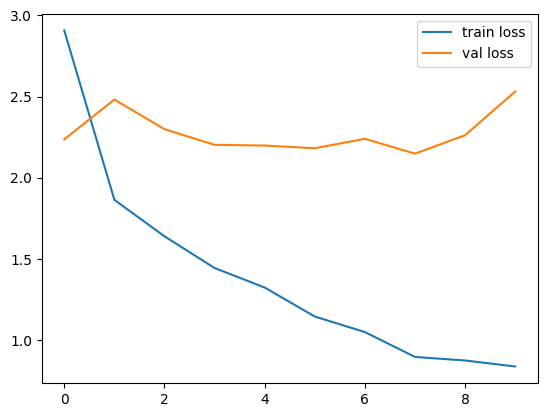

<Figure size 640x480 with 0 Axes>

In [139]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

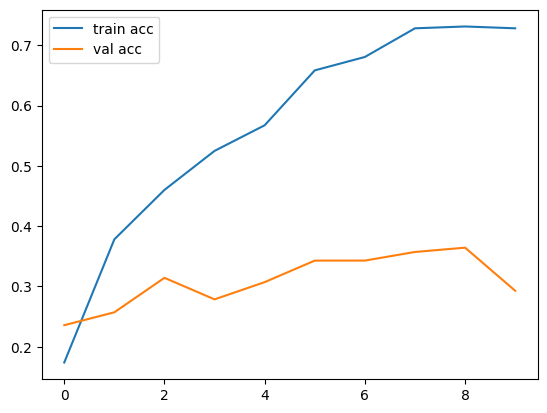

<Figure size 640x480 with 0 Axes>

In [140]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [141]:
#perf on test data
model.evaluate(test_set)

5/5 ━━━━━━━━━━━━━━━━━━━━ 89s 17s/step - accuracy: 0.2808 - loss: 2.4886


[2.5312423706054688, 0.2928571403026581]

In [142]:
#save model
from tensorflow.keras.models import load_model

model.save('model_vgg16.h5')

In [143]:
#load model
model = load_model("model_vgg16.h5")

In [144]:
#single image pred
from tensorflow.keras.preprocessing import image
img="/content/Bone Break Classification/FLATTENED_BONE_DATA/test/Spiral_Fracture/110001_jumbo_jpeg.rf.94b56c0454a24891c46456a32af0129c.jpg"

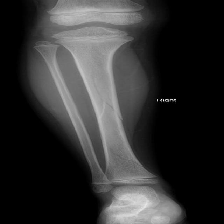

In [145]:
img=image.load_img(img,target_size=(224,224))
img

In [164]:
#convert to np array
x=image.img_to_array(img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

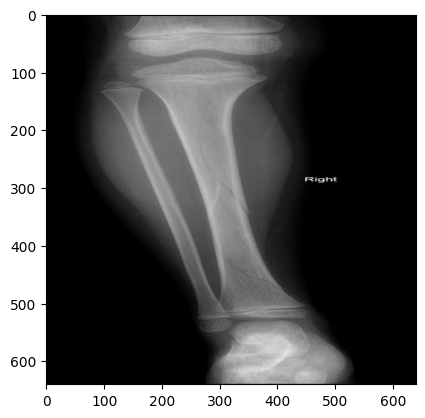

In [165]:
#visualization of image
Z = plt.imread('/content/Bone Break Classification/FLATTENED_BONE_DATA/test/Spiral_Fracture/110001_jumbo_jpeg.rf.94b56c0454a24891c46456a32af0129c.jpg')
plt.imshow(Z)

In [166]:
x.shape

(224, 224, 3)

In [167]:
#scaling
x=x/255

In [168]:
#preprocess
from keras.applications.vgg16 import preprocess_input
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)


In [169]:
#predict
output = model.predict(img_data)
output

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[4.0175092e-01, 2.6424759e-04, 1.1870515e-02, 1.9516288e-04,
        9.2155017e-02, 6.5567554e-05, 1.6523628e-03, 3.1924536e-03,
        1.6563328e-01, 3.2322055e-01]], dtype=float32)

In [170]:
x.shape

(1, 224, 224, 3)

In [172]:
import numpy as np

# 'output' is your model prediction
predicted_class = np.argmax(output)
confidence = output[0][predicted_class] * 100

class_labels = [
    'Avulsion_fracture',
    'Comminuted_fracture',
    'Fracture_Dislocation',
    'Greenstick_fracture',
    'Hairline_Fracture',
    'Impacted_fracture',
    'Longitudinal_fracture',
    'Oblique_fracture',
    'Pathological_fracture',
    'Spiral_Fracture'
]

print(f"Predicted Fracture Type: {class_labels[predicted_class]}")
print(f"Confidence: {confidence:.2f}%")

Predicted Fracture Type: Avulsion_fracture
Confidence: 40.18%
